To run this notebook on gridui

```
jupyter notebook --ip=* --port=8888
```

In [81]:
#configure the environment
import ROOT
import os
import math as M

In [82]:
#Some general functions
etaAcceptance = {} # fiducial regions
etaAcceptance['EB']= [ 0. , 1.4442 ] 
etaAcceptance['EE']= [ 1.566 , 2.5 ]

# Function to check if the electron belongs to ECAL barrel (EB) or endcap (EE)
# Check should be done on SuperCluster Eta not Track Eta 
def eleDet(iEle):
    for det in ['EB','EE']:
        if ( 
            abs(chain_in[sample].eleSCEta[iEle]) >= etaAcceptance[det][0]
            and abs(chain_in[sample].eleSCEta[iEle]) < etaAcceptance[det][1]  
            ):
            return det
    return 'OA' #out of acceptance

# Function to check if a reconstructed electron is matched to a generator electron
def has_mcEle_match(iEle):
    ele_vec = ROOT.TLorentzVector()
    # for momentum purposes you should use track eta (eleEta)
    ele_vec.SetPtEtaPhiE(chain_in[sample].elePt[iEle], chain_in[sample].eleEta[iEle],
                         chain_in[sample].elePhi[iEle], chain_in[sample].eleEn[iEle])

    for mc in range(chain_in[sample].nMC):
        if abs(chain_in[sample].mcPID[mc]) != 11 or chain_in[sample].mcPt[mc] < 15. or chain_in[sample].mcStatus[mc]!=1:
            continue
        mc_vec = ROOT.TLorentzVector()
        mc_vec.SetPtEtaPhiE(chain_in[sample].mcPt[mc], chain_in[sample].mcEta[mc], chain_in[sample].mcPhi[mc], chain_in[sample].mcE[mc])
        delta_r = ele_vec.DeltaR(mc_vec)
        if delta_r < 0.05:
            return True
    return False

# return the class for the electron ['eleMC', 'eleFake' ] for MC [ 'eleData' ] in Data
def eType(iEle,isMC): 
    if (isMC):
        if (has_mcEle_match(iEle)):
            return "eleMC"
        else:
            return "eleFake"
    else:
        return "eleData"

sw = ROOT.TStopwatch()


#return tighest level of cutBased eleID passed by the electron manipulating eleIDbit from ntuple
def eleID(eleIDbit):
    #bit 0 cutBasedElectronID-Fall17-94X-V1-veto 
    #bit 1 cutBasedElectronID-Fall17-94X-V1-loose 
    #bit 2 cutBasedElectronID-Fall17-94X-V1-medium 
    #bit 3 cutBasedElectronID-Fall17-94X-V1-tight 
    for i in range(3,-1,-1):
        if (eleIDbit>>i&1): #checks the i-th bit of the eleID bit starting from the MSB
            return i+1
    return 0
        

In [83]:
#Samples definition
max_entries = 10000

samples = ['dy','tt','doubleEG']
inputs ={}
inputs['doubleEG']=  { 'file':'/gpfs/ddn/cms/user/cmsdas/2019/EgammaExercise/CMSSW_9410/DoubleEG.root','isMC':False}
inputs['dy']=  { 'file':'/gpfs/ddn/cms/user/cmsdas/2019/EgammaExercise/CMSSW_9410/DY.root','isMC':True}
inputs['tt']=  { 'file':'/gpfs/ddn/cms/user/cmsdas/2019/EgammaExercise/CMSSW_9410/TTJets.root','isMC':True}

# Input ggNtuple
chain_in[sample] = {}
n_entries = {}
for sample in samples:
    chain_in[sample] = ROOT.TChain('ggNtuplizer/EventTree')
    chain_in[sample].Add(inputs[sample]['file'])

    # This speeds up processing by only reading the branches (quantities) that we plan to use later
    branches = ["nEle", "elePt", "eleEta", "elePhi", "eleEn", "eledPhiAtVtx", "eleHoverE", "eleEoverPInv", "eleConvVeto", "eleSigmaIEtaIEtaFull5x5",
            "eleSCEta", "eleSCPhi", "eleSCRawEn", "eleIDbit","eleIDMVAIso" ]
    if ( inputs[sample]['isMC'] ):
        branches.extend( [ "nMC", "mcPt", "mcEta", "mcPhi", "mcE", "mcPID","mcStatus"] )

    chain_in[sample].SetBranchStatus("*", 0)
    for b in branches:
        chain_in[sample].SetBranchStatus(b, 1)

    n_entries[sample] = chain_in[sample].GetEntries()
    print 'Sample '+sample+' events: '+ str(n_entries[sample])

Sample dy events: 100000
Sample tt events: 100000
Sample doubleEG events: 100000


In [84]:
#Book the necessary histograms
histos = {}

for sample in samples:

    eleTypes = []
    if (inputs[sample]['isMC']):
        eleTypes.extend(['eleMC' , 'eleFake'])
    else:
        eleTypes.extend(['eleData'])


    for eleType in eleTypes:
        for det in ['EB','EE']:
            histos[sample+'_'+eleType+'_'+det+'_pt']            = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_pt', 'Electron p_{T}', 190, 10.0, 200.0)
            histos[sample+'_'+eleType+'_'+det+'_eta']           = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_eta', 'Electron #eta', 50, 0., 2.5)
            histos[sample+'_'+eleType+'_'+det+'_phi']           = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_phi', 'Electron #phi', 100, -M.pi, M.pi)
            histos[sample+'_'+eleType+'_'+det+'_sigmaIEtaIEta'] = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_sigmaIEtaIEta', 'Electron #sigma_{i#eta i#eta}', 100, 0.0, 0.1)
            histos[sample+'_'+eleType+'_'+det+'_eleID']         = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_eleID', 'Electron ID (cut based)', 10, -0.5, 9.5)
            histos[sample+'_'+eleType+'_'+det+'_eleIDMVA']      = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_eleIDMVA', 'Electron ID (MVA)', 100, -1., 1.)
            histos[sample+'_'+eleType+'_'+det+'_pt'+'_eleID']   = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_pt'+'_eleID', 'Electron p_{T}', 190, 10.0, 200.0)
            histos[sample+'_'+eleType+'_'+det+'_eta'+'_eleID']  = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_eta'+'_eleID', 'Electron #eta', 50, 0., 2.5)
            histos[sample+'_'+eleType+'_'+det+'_phi'+'_eleID']  = ROOT.TH1F(sample+'_'+eleType+'_'+det+'_phi'+'_eleID', 'Electron #phi', 100, -M.pi, M.pi)

In [85]:
#Loop over all the events in the input ntuples

#start the clock
sw.Start()

for sample in samples:
    print ">>> Processing "+sample
    
    for j_entry in range(min(max_entries,n_entries[sample]) if max_entries>0 else n_entries[sample]):
        i_entry = chain_in[sample].LoadTree(j_entry)
        if i_entry < 0:
            break
        nb = chain_in[sample].GetEntry(j_entry)
        if nb <= 0:
            continue

        if j_entry % 1000 == 0:
            print 'Processing entry ' + str(j_entry)

        # Loop over all the electrons in an event
        for i in range(chain_in[sample].nEle):
            if (chain_in[sample].elePt[i] < 20. ):
                continue
            ele_det=eleDet(i)
            ele_type=eType(i,inputs[sample]['isMC']) 

            #fill reconstructed electron kinematics
            if (not ele_det == 'OA'):
                histos[sample+'_'+ele_type+'_'+ele_det+'_pt'].Fill(chain_in[sample].elePt[i])
                histos[sample+'_'+ele_type+'_'+ele_det+'_eta'].Fill(chain_in[sample].eleSCEta[i]) #use SCEta for efficiency studies
                histos[sample+'_'+ele_type+'_'+ele_det+'_phi'].Fill(chain_in[sample].elePhi[i])

            if ( #apply a simple and very loose preselection 
                ( 
                    (ele_det=='EB' #EB very loose preselection
                     and abs(chain_in[sample].eledPhiAtVtx[i]) < 0.2
                     and chain_in[sample].eleHoverE[i] < 0.1
                     and abs(chain_in[sample].eleEoverPInv[i]) < 0.3
                     and chain_in[sample].eleConvVeto[i] == 1 
                     )
                    or
                    (ele_det=='EE' #EE very loose preselection
                     and abs(chain_in[sample].eledPhiAtVtx[i]) < 0.25
                     and chain_in[sample].eleHoverE[i] < 0.15
                     and abs(chain_in[sample].eleEoverPInv[i]) < 0.2
                     and chain_in[sample].eleConvVeto[i] == 1 
                     )
                    )
                ):
                histos[sample+'_'+ele_type+'_'+ele_det+'_sigmaIEtaIEta'].Fill(chain_in[sample].eleSigmaIEtaIEtaFull5x5[i])
                histos[sample+'_'+ele_type+'_'+ele_det+'_eleID'].Fill(eleID(chain_in[sample].eleIDbit[i])) 
                histos[sample+'_'+ele_type+'_'+ele_det+'_eleIDMVA'].Fill(chain_in[sample].eleIDMVAIso[i]) 

                #store kinematic for efficiency plots 
                if (eleID(chain_in[sample].eleIDbit[i])>1): # pass cutBasedElectronID-Fall17-94X-V1-loose
                    histos[sample+'_'+ele_type+'_'+ele_det+'_pt'+'_eleID'].Fill(chain_in[sample].elePt[i])
                    histos[sample+'_'+ele_type+'_'+ele_det+'_eta'+'_eleID'].Fill(chain_in[sample].eleSCEta[i])
                    histos[sample+'_'+ele_type+'_'+ele_det+'_phi'+'_eleID'].Fill(chain_in[sample].elePhi[i])


#stop the clock
sw.Stop()

print '+++++++++++++++++++++++++++++++++++++++++++'
print 'Real time: ' + str(sw.RealTime() / 60.0) + ' minutes'
print 'CPU time:  ' + str(sw.CpuTime() / 60.0) + ' minutes'
print '+++++++++++++++++++++++++++++++++++++++++++'

>>> Processing dy
Processing entry 0
Processing entry 1000
Processing entry 2000
Processing entry 3000
Processing entry 4000
Processing entry 5000
Processing entry 6000
Processing entry 7000
Processing entry 8000
Processing entry 9000
>>> Processing tt
Processing entry 0
Processing entry 1000
Processing entry 2000
Processing entry 3000
Processing entry 4000
Processing entry 5000
Processing entry 6000
Processing entry 7000
Processing entry 8000
Processing entry 9000
>>> Processing doubleEG
Processing entry 0
Processing entry 1000
Processing entry 2000
Processing entry 3000
Processing entry 4000
Processing entry 5000
Processing entry 6000
Processing entry 7000
Processing entry 8000
Processing entry 9000
+++++++++++++++++++++++++++++++++++++++++++
Real time: 0.242215283712 minutes
CPU time:  0.281666666667 minutes
+++++++++++++++++++++++++++++++++++++++++++


In [86]:
#Configuration for plots 

output='plots'
title='CMSDAS2019 e/#gamma'

if not os.path.exists(output): 
    print('>>> Creating dir: '+output)
    os.makedirs(output) 

def saveCanvas(c,n):
    defaultTitle(0.1,0.91,title)
    for ext in ['.png','.pdf','.root' ]:
        c.SaveAs(output+"/"+n+ext)

def defaultTitle(x,y,text):
    t=ROOT.TLatex()
    t.SetTextSize(0.035)
    t.DrawLatexNDC(x,y,text)
    


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_roc
Info in <TCanvas::Print>: png file plots/roc_EB_sigmaIEtaIEta.png has been created
Info in <TCanvas::Print>: pdf file plots/roc_EB_sigmaIEtaIEta.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file plots/roc_EB_sigmaIEtaIEta.root has been created
Info in <TCanvas::Print>: png file plots/roc_EE_sigmaIEtaIEta.png has been created
Info in <TCanvas::Print>: pdf file plots/roc_EE_sigmaIEtaIEta.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file plots/roc_EE_sigmaIEtaIEta.root has been created


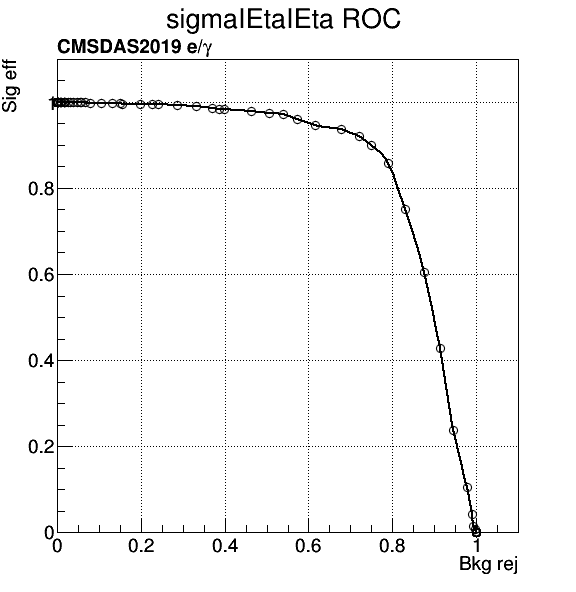

In [87]:
# produce the ROC curves

# vars for which you want the ROCs
vars =  [ 'sigmaIEtaIEta' ]

c_roc = ROOT.TCanvas('c_roc', '', 580, 620)
c_roc.SetGrid()
c_roc.Draw()


h_sig={}
h_bkg={}
g_roc={}


for var_name in vars:
    for det in ['EB','EE']: #rocs done separately for EB & EE
        h_sig[det + '_' + var_name] = histos['dy_eleMC_'   + det + '_' +var_name] # use DY for signal
        h_bkg[det + '_' + var_name] = histos['tt_eleFake_' + det + '_' +var_name] # use TTJets for bkg
        g_roc[det + '_' + var_name] = ROOT.TGraph()
        for i in range(h_sig[det + '_' + var_name].GetNbinsX()): #assumes here a cut var>cut
            eff_sig = h_sig[det + '_' + var_name].Integral(1, i + 1) / h_sig[det + '_' + var_name].Integral()
            eff_bkg = h_bkg[det + '_' + var_name].Integral(1, i + 1) / h_bkg[det + '_' + var_name].Integral()
            g_roc[det + '_' + var_name].SetPoint(i, 1.0 - eff_bkg, eff_sig)
        g_roc[det + '_' + var_name].GetXaxis().SetRangeUser(0.0, 1.1)
        g_roc[det + '_' + var_name].GetYaxis().SetRangeUser(0.0, 1.1)
        g_roc[det + '_' + var_name].GetXaxis().SetTitle('Bkg rej')
        g_roc[det + '_' + var_name].GetYaxis().SetTitle('Sig eff')
        g_roc[det + '_' + var_name].SetLineWidth(2)
        g_roc[det + '_' + var_name].SetMarkerStyle(24)
        g_roc[det + '_' + var_name].SetTitle(var_name + ' ROC')
        g_roc[det + '_' + var_name].Draw('APC')
        saveCanvas(c_roc,'roc_' + det + '_' + var_name)
        c_roc.Update()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_eff
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 82 points have been skipped
Info in <TCanvas::Print>: png file plots/eff_EB_pt_eleID.png has been created
Info in <TCanvas::Print>: pdf file plots/eff_EB_pt_eleID.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file plots/eff_EB_pt_eleID.root has been created
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 94 points have been skipped
Info in <TCanvas::Print>: png file plots/eff_EE_pt_eleID.png has been created
Info in <TCanvas::Print>: pdf file plots/eff_EE_pt_eleID.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file plots/eff_EE_pt_eleID.root has been created


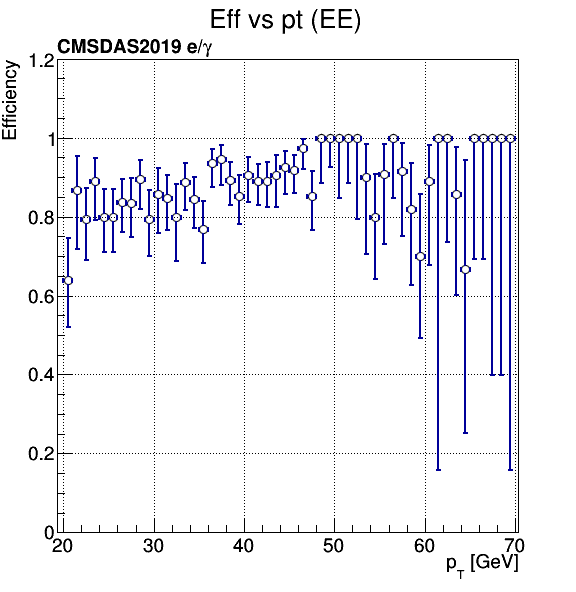

In [88]:
#different selections for which you want to compute efficiency
sel =  [ 'eleID' ] 

c_eff = ROOT.TCanvas('c_eff', '', 580, 620)
c_eff.SetGrid()
c_eff.Draw()

g_eff={}

ranges={}
ranges['pt']=[ 20, 70. ]
ranges['eta']=[ 0. , 3. ]
ranges['phi']=[ -M.pi , M.pi ]

axisT={}
axisT['pt']= 'p_{T} [GeV]' 
axisT['eta']= '#eta' 
axisT['phi']= '#phi' 

for var_name in sel:
    for det in ['EB','EE']:
        for t in [ 'pt' ]:
            #doing the ratios of the histograms to get the efficiency (e.g. PASS='h_eleMC_EB_pt_eleID',TOTAL='h_eleMC_EB_pt')
            g_eff[det+'_'+t+'_'+var_name] = ROOT.TGraphAsymmErrors( histos['dy_eleMC_'+det+'_'+t+'_'+var_name], histos['dy_eleMC_'+det+'_'+t])
            g_eff[det+'_'+t+'_'+var_name].GetXaxis().SetRangeUser(ranges[t][0],ranges[t][1])
            g_eff[det+'_'+t+'_'+var_name].GetYaxis().SetRangeUser(0.,1.2)
            g_eff[det+'_'+t+'_'+var_name].GetXaxis().SetTitle(axisT[t])
            g_eff[det+'_'+t+'_'+var_name].GetYaxis().SetTitle('Efficiency')
            g_eff[det+'_'+t+'_'+var_name].SetLineWidth(2)
            g_eff[det+'_'+t+'_'+var_name].SetMarkerStyle(24)
            g_eff[det+'_'+t+'_'+var_name].SetTitle( 'Eff vs '+ t + ' ('+det+')' )
            g_eff[det+'_'+t+'_'+var_name].Draw('AP')
            saveCanvas(c_eff,'eff_' + det + '_' + t + '_' + var_name)
            c_eff.Update()